In [1]:
import Dataset as ds
import config as cfg
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [3]:
project_name= cfg.PROJECT_NAME + '/tf_clf'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

epochs = 20

_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [4]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

Label correction completed.


In [5]:

#augmentation_metadata = {
#    'methods': {        
#        'zoom': {
#            'parameters': {
#                'zoom_factor': 5,  # 50% of full zoom
#            },
#            'apply_to_percentage': 0.5  # 50% of the training images
#        }        
#    }
#}

augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

In [6]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/500 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/750 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/100 [00:00<?, ?it/s]

# ClearML
https://app.clear.ml/dashboard

# Image Classifier

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from clearml import Task
import clearml
clearml.browser_login()



In [8]:
## check GPU available
#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#
## limit vram usage
#for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
# directories of train, train-aug and validation
train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
train_aug_data = tf.keras.utils.image_dataset_from_directory(train_aug_dir)
valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir)

# scale images between 0 and 1
train_data = train_data.map(lambda x,y: (x/255, y))
train_aug_data = train_aug_data.map(lambda x,y: (x/255, y))
valid_data = valid_data.map(lambda x,y: (x/255, y))

Found 500 files belonging to 3 classes.
Found 750 files belonging to 3 classes.
Found 100 files belonging to 3 classes.


In [10]:
# TEST - use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_iterator = train_data.as_numpy_iterator()
train_batch = train_iterator.next()

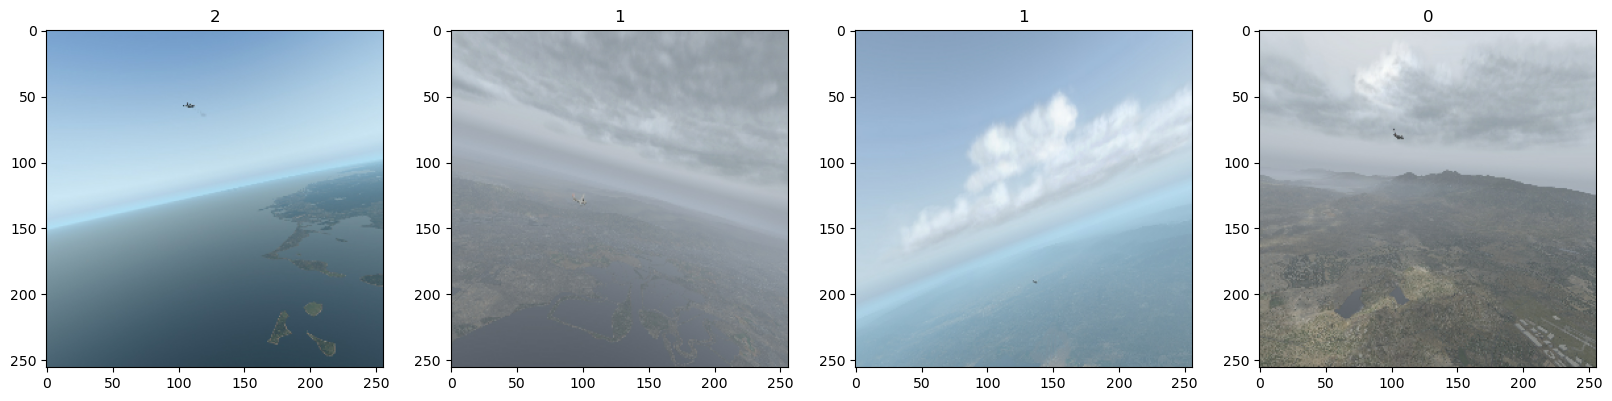

In [11]:
# TEST - visualise images with class labels
train_batch = train_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(train_batch[1][idx])


In [12]:
# use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_data.as_numpy_iterator().next()
train_aug_data.as_numpy_iterator().next()
valid_data.as_numpy_iterator().next()

print("done")


done


In [13]:
# model architecture - Also try ResNet50 or VGG16
#model = Sequential()
#model.add(Input(shape=(256,256,3)))  # Add an Input layer to specify the input shape
#model.add(Conv2D(32, (3,3), activation='relu'))  # Notice that we no longer need to specify the input_shape here
#model.add(MaxPooling2D())
#model.add(Conv2D(32, (3,3), activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(16, (3,3), activation='relu'))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes
#
#model.compile(optimizer='adam', 
#              loss='sparse_categorical_crossentropy', 
#              metrics=['accuracy'])
#model.summary()



# Load the ResNet50 base model, excluding its top fully connected layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for our dataset with 3 classes
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units and relu activation
predictions = Dense(3, activation='softmax')(x)  # Add a final softmax layer with 3 classes

# Create the final model by combining base model with our custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the Adam optimizer and sparse categorical cross-entropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# train pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

# trian model
train_hst = model.fit(train_data, epochs=hyper_params['epochs'], validation_data=valid_data, callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
# close task
task.close()

ClearML Task: created new task id=91b86e589ab14d8da9bdbbefe23772a0
2024-04-21 04:43:30,877 - clearml.Task - INFO - Storing jupyter notebook directly as code


ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/91b86e589ab14d8da9bdbbefe23772a0/output/log
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2979 - loss: 2.3245 - val_accuracy: 0.3300 - val_loss: 1.1663
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2868 - loss: 1.2871 - val_accuracy: 0.3400 - val_loss: 1.1076
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3374 - loss: 1.1757 - val_accuracy: 0.3400 - val_loss: 1.1094
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3442 - loss: 1.1442 - val_accuracy: 0.3400 - val_loss: 1.1946
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.2955 - loss: 1.2400 - val_accuracy: 0.3300 - val_loss: 1.1372
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3765 -

In [15]:
# train aug

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

# trian model
train_hst = model.fit(train_aug_data, epochs=hyper_params['epochs'], validation_data=valid_data, callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
# close task
task.close()

ClearML Task: created new task id=c07bd02afd4e401f9569e6591973c3aa
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/c07bd02afd4e401f9569e6591973c3aa/output/log
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3487 - loss: 1.1193 - val_accuracy: 0.3400 - val_loss: 1.1385
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2981 - loss: 1.1382 - val_accuracy: 0.3400 - val_loss: 1.1653
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3382 - loss: 1.1319 - val_accuracy: 0.3300 - val_loss: 1.1210
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3486 - loss: 1.1249 - val_accuracy: 0.3500 - val_loss: 1.1139
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.3218 - loss: 1.1177 - val_accuracy: 0.3300 - val_loss: 1.1346
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3520 - loss: 1.1173 - val_accuracy: 0.3400 - val_loss: 1.1850
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━